here we perform a dynamic network analysis of international football matches based on historical data. It begins by loading the data from a CSV file and converting the date columns into a standard datetime format. The data is then filtered by decades, and each decade is analyzed separately by constructing a network graph where nodes represent football teams, and edges represent the matches between them. The edges are weighted based on the goal difference in each match.

Next, the cell identifies communities within the network using the Greedy Modularity algorithm and calculates centrality measures for each team, including Degree Centrality, Closeness Centrality, and Betweenness Centrality. The results for each decade are stored, and the code provides insights into the number of communities in each decade. This allows for an in-depth analysis of the community structure and changes in regional dominance within international football over time.

In [ ]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community

# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/BarShnider/soccer-network-analysis/main/international_matches.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Function to filter data by decade
def filter_by_decade(df, start_year, end_year):
    return df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]

# Function to create a graph from a filtered dataset
def create_graph(df_filtered):
    G = nx.Graph()

    # Add nodes (teams)
    teams = set(df_filtered['home_team']).union(set(df_filtered['away_team']))
    G.add_nodes_from(teams)

    # Add edges with weights (based on match results)
    for index, row in df_filtered.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        weight = row['home_team_score'] - row['away_team_score']

        if G.has_edge(home_team, away_team):
            G[home_team][away_team]['weight'] += abs(weight)
        else:
            G.add_edge(home_team, away_team, weight=abs(weight))

    return G

# Function to detect communities using Greedy Modularity algorithm
def detect_communities(G):
    communities_generator = community.greedy_modularity_communities(G)
    partition = {node: cid for cid, community in enumerate(communities_generator) for node in community}
    return partition

# Function to calculate centrality measures
def calculate_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Adding centrality measures as node attributes
    nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
    nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')
    nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

# Process each decade
decades = [(1990, 1999), (2000, 2009), (2010, 2020)]
graphs = {}

for start_year, end_year in decades:
    # Filter data for the decade
    df_filtered = filter_by_decade(df, start_year, end_year)

    # Create the graph
    G = create_graph(df_filtered)

    # Detect communities
    partition = detect_communities(G)

    # Assign community labels to nodes
    nx.set_node_attributes(G, partition, 'community')

    # Calculate centrality measures
    calculate_centrality_measures(G)

    # Store the graph
    graphs[f'{start_year}-{end_year}'] = G

# Counting the number of communities in each decade
for decade, G in graphs.items():
    communities = nx.get_node_attributes(G, 'community')
    num_communities = len(set(communities.values()))
    print(f"{decade}: {num_communities} communities")


1990-1999: 4 communities
2000-2009: 4 communities
2010-2020: 3 communities


this cell help visually represent the community structure within international matches networks for different decades. It uses the matplotlib library for plotting and the networkx library for handling graph operations.

The `plot_communities` function is defined to create a visual representation of the network graph, with nodes color-coded based on their community membership. The function uses a spring layout to position the nodes. The color of each node is determined by the community to which it belongs, and these colors are assigned using a colormap.

The function is then used to plot the network graphs for three different decades: the 1990s, 2000s, and 2010s. For each decade, the corresponding graph (**G_1990s, G_2000s, G_2010s**) is retrieved from a previously generated dictionary of graphs. The community partitions, stored as node attributes in each graph, are extracted and passed to the `plot_communities` function to generate and display the plots. Each plot provides a visual insight into the community structure of international football teams during the respective decade, illustrating how teams cluster into different communities based on their interactions.

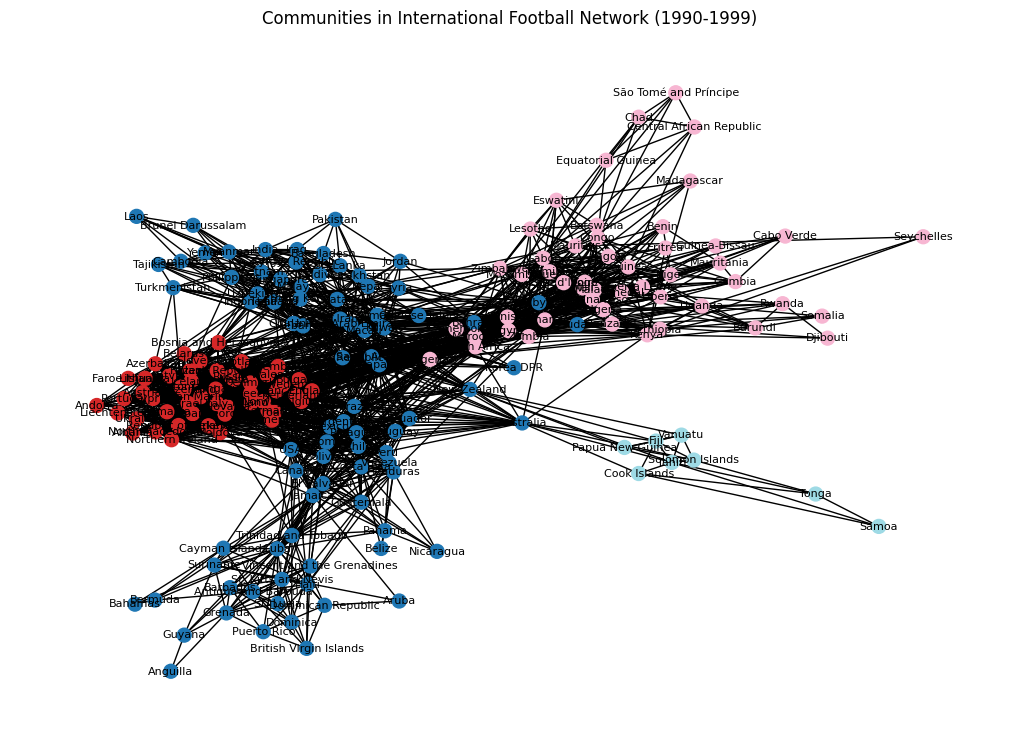

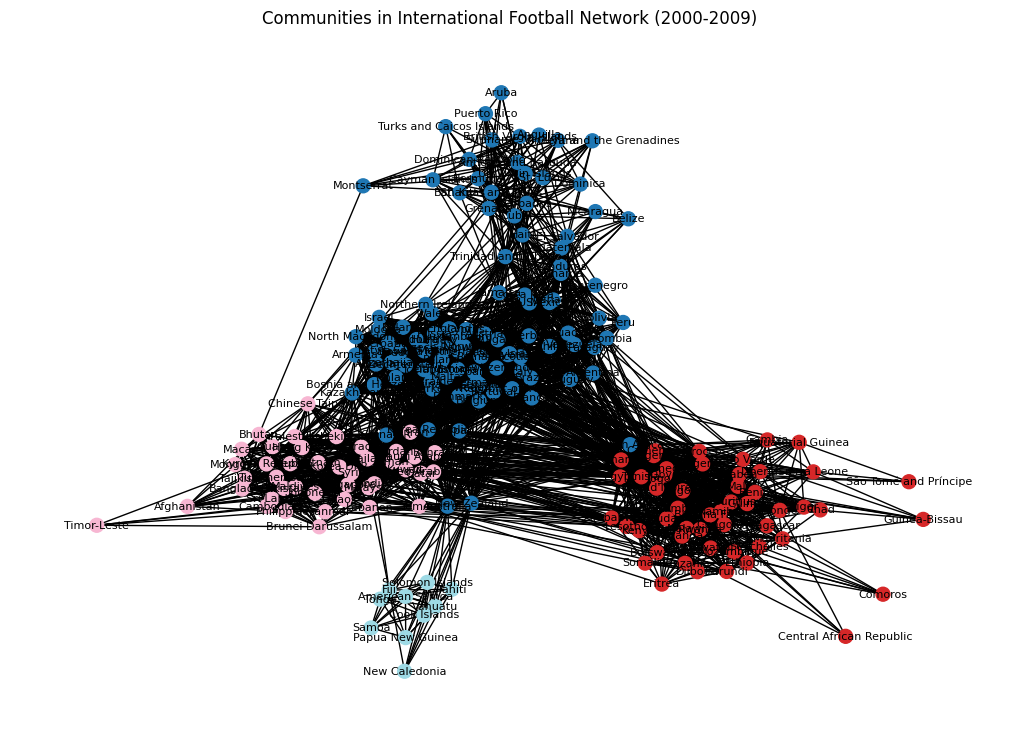

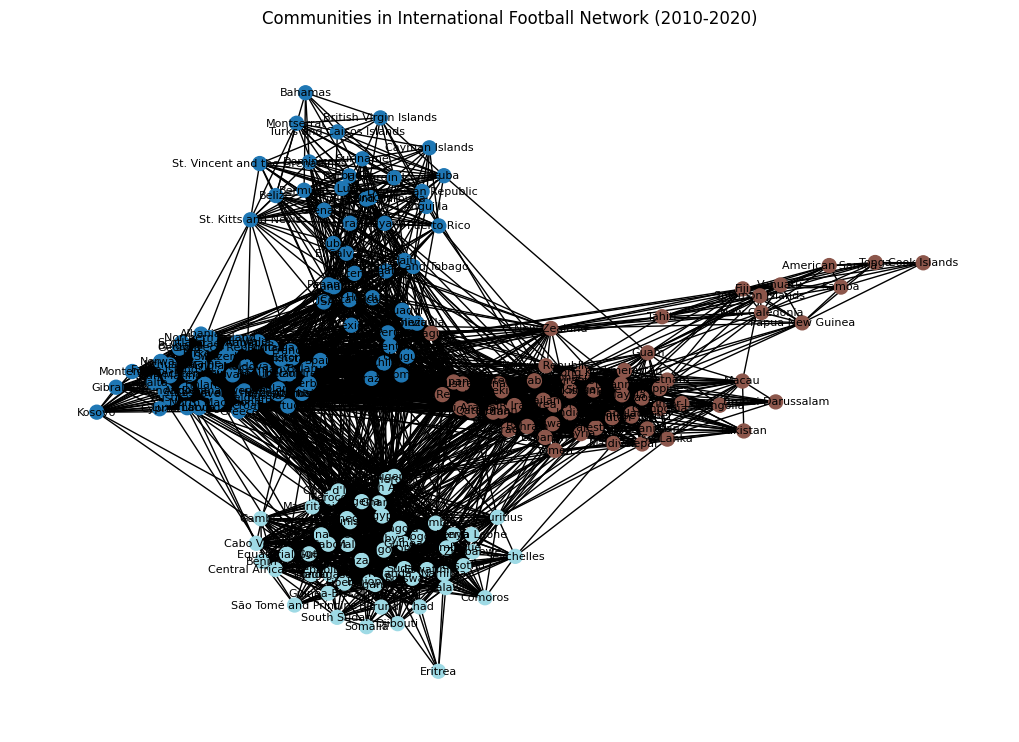

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to plot the graph with communities
def plot_communities(G, partition, title):
    # Assign colors to each community
    colors = [partition[node] for node in G.nodes()]

    # Draw the graph
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)  # Positioning the nodes using the spring layout
    nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab20, node_size=100, font_size=8)
    plt.title(title)
    plt.show()

# Example: Plotting the graph for the 1990s
G_1990s = graphs['1990-1999']
partition_1990s = nx.get_node_attributes(G_1990s, 'community')
plot_communities(G_1990s, partition_1990s, "Communities in International Football Network (1990-1999)")

# Example: Plotting the graph for the 2000s
G_2000s = graphs['2000-2009']
partition_2000s = nx.get_node_attributes(G_2000s, 'community')
plot_communities(G_2000s, partition_2000s, "Communities in International Football Network (2000-2009)")

# Example: Plotting the graph for the 2010s
G_2010s = graphs['2010-2020']
partition_2010s = nx.get_node_attributes(G_2010s, 'community')
plot_communities(G_2010s, partition_2010s, "Communities in International Football Network (2010-2020)")


This cell help us analyze and summarize the community structure and centrality measures within international football networks across different decades. It performs the following tasks:

1. **Community Summary**: The `summarize_communities` function calculates the number of communities in the network and the size of each community (i.e., the number of nodes or teams within each community). It returns these metrics, which provide insights into how teams are grouped within each network.

2. **Centrality Summary**: The `summarize_centralities` function calculates average centrality measures for each community. It computes the average Degree Centrality, Closeness Centrality, and Betweenness Centrality for the nodes within each community. These metrics help in understanding the influence and connectivity of teams within their respective communities.

3. **Analysis by Decade**: The code then iterates over the network graphs for each decade (1990-1999, 2000-2009, 2010-2020) stored in the graphs dictionary. For each decade:
  * It retrieves the community partition data from the graph.
  * It summarizes the community data using the `summarize_communities` function.
  * It summarizes the centrality data for each community using the `summarize_centralities` function.
  * It stores these results in the **`comparison_summary`** dictionary, which organizes the number of communities, their sizes, and their centrality metrics by decade.

The final **`comparison_summary`** dictionary contains a comprehensive analysis of the community structures and centrality measures across the decades, enabling further comparison and interpretation of the evolving dynamics in international football networks.

In [ ]:
import pandas as pd

# Function to summarize community data
def summarize_communities(G, partition):
    # Number of communities
    num_communities = len(set(partition.values()))

    # Size of each community (number of nodes)
    community_sizes = pd.Series(list(partition.values())).value_counts().sort_index()

    return num_communities, community_sizes

# Function to calculate average centrality measures for each community
def summarize_centralities(G, partition):
    communities = set(partition.values())

    summary = {}
    for community in communities:
        nodes_in_community = [node for node in G.nodes() if partition[node] == community]

        avg_degree_centrality = sum(nx.get_node_attributes(G, 'degree_centrality')[node] for node in nodes_in_community) / len(nodes_in_community)
        avg_closeness_centrality = sum(nx.get_node_attributes(G, 'closeness_centrality')[node] for node in nodes_in_community) / len(nodes_in_community)
        avg_betweenness_centrality = sum(nx.get_node_attributes(G, 'betweenness_centrality')[node] for node in nodes_in_community) / len(nodes_in_community)

        summary[community] = {
            'avg_degree_centrality': avg_degree_centrality,
            'avg_closeness_centrality': avg_closeness_centrality,
            'avg_betweenness_centrality': avg_betweenness_centrality,
            'num_nodes': len(nodes_in_community)
        }

    return pd.DataFrame(summary).T

# Perform the analysis for each decade
comparison_summary = {}

for decade, G in graphs.items():
    partition = nx.get_node_attributes(G, 'community')

    # Summarize community data
    num_communities, community_sizes = summarize_communities(G, partition)

    # Summarize centrality data
    centrality_summary = summarize_centralities(G, partition)

    # Store the results
    comparison_summary[decade] = {
        'num_communities': num_communities,
        'community_sizes': community_sizes,
        'centrality_summary': centrality_summary
    }

comparison_summary



{'1990-1999': {'num_communities': 4,
  'community_sizes': 0    85
  1    50
  2    49
  3     8
  Name: count, dtype: int64,
  'centrality_summary':    avg_degree_centrality  avg_closeness_centrality  \
  0               0.095042                  0.413412   
  1               0.161152                  0.451595   
  2               0.097660                  0.410577   
  3               0.027487                  0.316535   
  
     avg_betweenness_centrality  num_nodes  
  0                    0.009177       85.0  
  1                    0.004522       50.0  
  2                    0.008869       49.0  
  3                    0.002814        8.0  },
 '2000-2009': {'num_communities': 4,
  'community_sizes': 0    103
  1     52
  2     42
  3     10
  Name: count, dtype: int64,
  'centrality_summary':    avg_degree_centrality  avg_closeness_centrality  \
  0               0.181968                  0.481169   
  1               0.140963                  0.457232   
  2               0.1516


Here we analyze and visualize the trends in centrality measures of international football networks over multiple decades, as well as to identify the most central teams in each decade. The tasks are divided into two main functions:

**1. Plotting Centrality Trends:**

* The `plot_centrality_trends` function extracts the average centrality measures (Degree Centrality, Closeness Centrality, and Betweenness Centrality) for each decade from the **`comparison_summary`** dictionary.
* It then plots these averages across the decades to visualize the trends in these centrality measures over time. The plot helps in identifying how the influence and connectivity of teams in the network have evolved across different periods.

**2. Identifying Top Central Nodes:**

* The `identify_top_central_nodes` function identifies the top `N` teams (nodes) in each network based on their centrality measures.
* For each decade, the function ranks the teams by Degree Centrality, Closeness Centrality, and Betweenness Centrality, and returns the top `N` teams for each measure.
* This information is then stored in the **`top_nodes_summary`** dictionary, providing a decade-wise summary of the most central teams in the international football networks.
The output of these functions includes a plot showing how centrality measures have changed over the decades and a dictionary (**`top_nodes_summary`**) detailing the top teams in terms of centrality for each decade. This analysis allows for a deeper understanding of which teams have been the most influential in international football networks and how their influence has shifted over time.

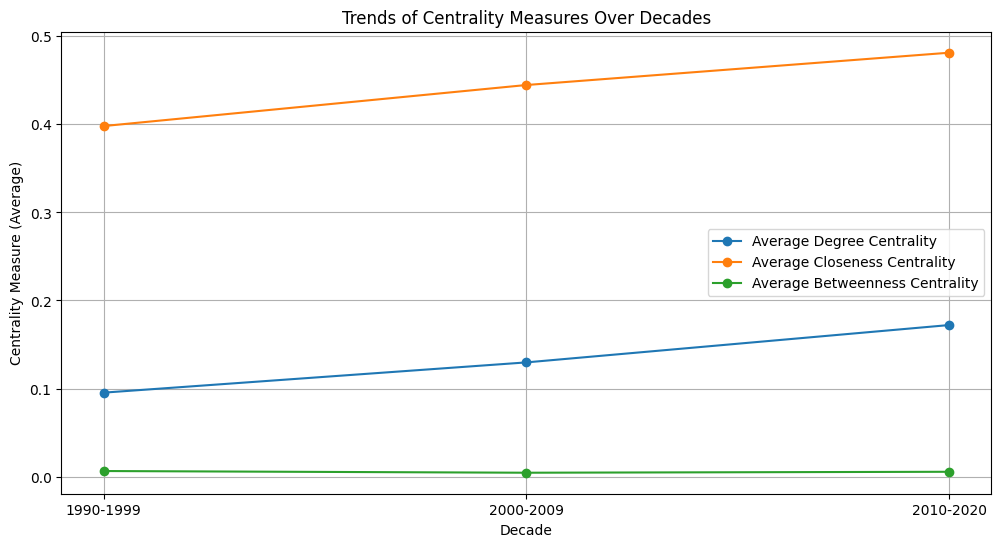

{'1990-1999': {'top_degree': [('Saudi Arabia', 0.30366492146596863),
   ('Norway', 0.2670157068062827),
   ('Germany', 0.2617801047120419),
   ('Mexico', 0.25654450261780104),
   ('Brazil', 0.25130890052356025)],
  'top_closeness': [('Saudi Arabia', 0.5718562874251497),
   ('Korea Republic', 0.532033426183844),
   ('Brazil', 0.5290858725761773),
   ('Ghana', 0.5290858725761773),
   ('Norway', 0.5276243093922652)],
  'top_betweenness': [('Jamaica', 0.0813487959263053),
   ('Saudi Arabia', 0.08046300441681627),
   ('Australia', 0.04932588196042498),
   ('Trinidad and Tobago', 0.045920986510086415),
   ('Ghana', 0.04242391660733696)]},
 '2000-2009': {'top_degree': [('Japan', 0.3834951456310679),
   ('South Africa', 0.3543689320388349),
   ('Korea Republic', 0.3398058252427184),
   ('Germany', 0.3252427184466019),
   ('Saudi Arabia', 0.3252427184466019)],
  'top_closeness': [('Japan', 0.6058823529411764),
   ('Korea Republic', 0.5919540229885057),
   ('South Africa', 0.5902578796561605),
 

In [ ]:
import matplotlib.pyplot as plt

# Function to plot trends of centrality measures over decades
def plot_centrality_trends(comparison_summary):
    decades = []
    avg_degree = []
    avg_closeness = []
    avg_betweenness = []

    for decade, data in comparison_summary.items():
        decades.append(decade)
        avg_degree.append(data['centrality_summary']['avg_degree_centrality'].mean())
        avg_closeness.append(data['centrality_summary']['avg_closeness_centrality'].mean())
        avg_betweenness.append(data['centrality_summary']['avg_betweenness_centrality'].mean())

    # Plotting the trends
    plt.figure(figsize=(12, 6))

    plt.plot(decades, avg_degree, marker='o', label='Average Degree Centrality')
    plt.plot(decades, avg_closeness, marker='o', label='Average Closeness Centrality')
    plt.plot(decades, avg_betweenness, marker='o', label='Average Betweenness Centrality')

    plt.title('Trends of Centrality Measures Over Decades')
    plt.xlabel('Decade')
    plt.ylabel('Centrality Measure (Average)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to identify top N central nodes in each decade
def identify_top_central_nodes(G, top_n=5):
    degree_centrality = nx.get_node_attributes(G, 'degree_centrality')
    closeness_centrality = nx.get_node_attributes(G, 'closeness_centrality')
    betweenness_centrality = nx.get_node_attributes(G, 'betweenness_centrality')

    # Sort and get top N nodes
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return top_degree, top_closeness, top_betweenness

# Plot trends of centrality measures over decades
plot_centrality_trends(comparison_summary)

# Identify top 5 central nodes in each decade
top_nodes_summary = {}
for decade, G in graphs.items():
    top_degree, top_closeness, top_betweenness = identify_top_central_nodes(G)
    top_nodes_summary[decade] = {
        'top_degree': top_degree,
        'top_closeness': top_closeness,
        'top_betweenness': top_betweenness
    }

top_nodes_summary


here we are detecting and summarizing the community structures within international football networks across different decades. The process involves the following steps:

1. **Finding Communities**:
   - The `find_communities` function uses the Greedy Modularity algorithm to detect communities within a given network graph (`G`). This algorithm is effective in identifying groups of nodes (teams) that are more densely connected internally than with the rest of the network.
   - After detecting the communities, the function converts the results into a dictionary (`communities_dict`), where each node (team) is assigned a community ID.
   - The function also calculates the size of each community (i.e., the number of nodes within each community) and stores these sizes in a list (`community_sizes`).

2. **Analyzing Communities by Decade**:
   - The code iterates over the network graphs for each decade (1990-1999, 2000-2009, 2010-2020) stored in the `graphs` dictionary.
   - For each decade, it applies the `find_communities` function to detect communities and summarize their sizes.
   - The results for each decade, including the community assignments (`communities_dict`) and the sizes of the communities (`community_sizes`), are stored in the `communities_summary` dictionary.

The final output is the `communities_summary` dictionary, which contains detailed information about the community structures for each decade.

In [ ]:
import networkx as nx
from networkx.algorithms import community

# Function to find and summarize communities
def find_communities(G):
    # Detect communities using the Greedy Modularity algorithm
    communities_generator = community.greedy_modularity_communities(G)

    # Convert to a dictionary format where each node is assigned to a community
    communities_dict = {node: cid for cid, community in enumerate(communities_generator) for node in community}

    # Summarize the size of each community
    community_sizes = [len(community) for community in communities_generator]

    return communities_dict, community_sizes

# Analyze communities for each decade
communities_summary = {}

for decade, G in graphs.items():
    communities_dict, community_sizes = find_communities(G)
    communities_summary[decade] = {
        'communities_dict': communities_dict,
        'community_sizes': community_sizes
    }

communities_summary

{'1990-1999': {'communities_dict': {'Uzbekistan': 0,
   'Chinese Taipei': 0,
   'Libya': 0,
   'Aruba': 0,
   'Kazakhstan': 0,
   'Oman': 0,
   'Trinidad and Tobago': 0,
   'Vietnam': 0,
   'Yemen': 0,
   'Belize': 0,
   'Cambodia': 0,
   'St. Lucia': 0,
   'Puerto Rico': 0,
   'Syria': 0,
   'India': 0,
   'Japan': 0,
   'Singapore': 0,
   'Panama': 0,
   'Hong Kong': 0,
   'Brazil': 0,
   'Cuba': 0,
   'Anguilla': 0,
   'Malaysia': 0,
   'Bahamas': 0,
   'New Zealand': 0,
   'Grenada': 0,
   'Korea DPR': 0,
   'St. Kitts and Nevis': 0,
   'Kuwait': 0,
   'Myanmar': 0,
   'British Virgin Islands': 0,
   'Peru': 0,
   'Pakistan': 0,
   'USA': 0,
   'Antigua and Barbuda': 0,
   'Philippines': 0,
   'Bolivia': 0,
   'Barbados': 0,
   'Honduras': 0,
   'Korea Republic': 0,
   'Argentina': 0,
   'Bermuda': 0,
   'Dominica': 0,
   'Costa Rica': 0,
   'Guatemala': 0,
   'Sudan': 0,
   'Mexico': 0,
   'Uruguay': 0,
   'Indonesia': 0,
   'Sri Lanka': 0,
   'Tajikistan': 0,
   'Suriname': 0,
  